In [1]:
#Necesitamos instalar pip install nltk
import nltk
#Descargar los recursos necesarios para la tokenización
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Diws\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [22]:
#Importacion de librerias necesarias
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

In [3]:
#Descagar las wordnet necesarias
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Diws\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Diws\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#Cargamos el dataset
df = pd.read_csv('train_sentiment.csv', encoding='latin-1')
#Verificamos su carga con la impresion de las primeras filas
print(df.head())

   0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY _TheSpecialOne_  \
0  0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   scotthamilton   
1  0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY        mattycus   
2  0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         ElleCTF   
3  0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY          Karoli   
4  0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY        joy_wolf   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....           

In [5]:
#Verificamos sus dimensiones
print(f"El data set tienen {df.shape[0]}, filas y {df.shape[1]} columnas")

El data set tienen 1599999, filas y 6 columnas


In [6]:
#Verificamos las columnas disponibles
print(f"Columnas del data set: {df.columns}")

Columnas del data set: Index(['0', '1467810369', 'Mon Apr 06 22:19:45 PDT 2009', 'NO_QUERY',
       '_TheSpecialOne_',
       '@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'],
      dtype='object')


In [11]:
# Check if the first column exists before replacing values
if df.shape[1] > 0:
    first_column_name = df.columns[0]
    df[first_column_name] = df[first_column_name].replace(4, 1).replace(0, -1)
else:
    print("The dataframe does not have any columns.")


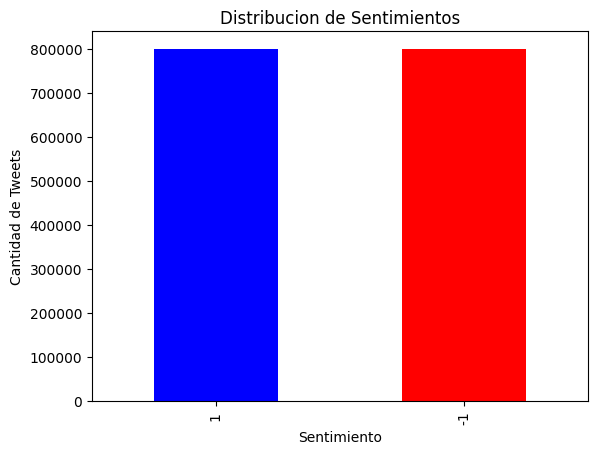

In [12]:
#Graficamos la distribucion de los sentimientos
df[first_column_name].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribucion de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Tweets')
plt.show()

Paso extra para la ultima columna guardarla con un nombre

In [13]:
#La columna texto es la utlima por lo tanto
last_column_name = df.columns[5]
print("Los primeros 10 datos de la columna texto son:")
print(df[last_column_name].head(10))

Los primeros 10 datos de la columna texto son:
0    is upset that he can't update his Facebook by ...
1    @Kenichan I dived many times for the ball. Man...
2      my whole body feels itchy and like its on fire 
3    @nationwideclass no, it's not behaving at all....
4                        @Kwesidei not the whole crew 
5                                          Need a hug 
6    @LOLTrish hey  long time no see! Yes.. Rains a...
7                 @Tatiana_K nope they didn't have it 
8                            @twittera que me muera ? 
9          spring break in plain city... it's snowing 
Name: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D, dtype: object


In [14]:
#Seleccionamos las columnas de interes [target y text] [first_column_name,last_column_name]
df=df[[first_column_name,last_column_name]]
#Verificamos la seleccion
print(df.head())

   0  \
0 -1   
1 -1   
2 -1   
3 -1   
4 -1   

  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D  
0  is upset that he can't update his Facebook by ...                                                                   
1  @Kenichan I dived many times for the ball. Man...                                                                   
2    my whole body feels itchy and like its on fire                                                                    
3  @nationwideclass no, it's not behaving at all....                                                                   
4                      @Kwesidei not the whole crew                                                                    


In [15]:
#Comprobamos si existen valores faltantes
print(df.isnull().sum())

0                                                                                                                      0
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D    0
dtype: int64


In [16]:
#Eliminamos filas con textos vacios
df=df.dropna(subset=[last_column_name])
#Verificamos la eliminacion
print(f"Filas despues de eliminar valores faltantes: {df.shape[0]}")

Filas despues de eliminar valores faltantes: 1599999


In [17]:
#Ahora eliminamos las entradas duplicadas
df=df.drop_duplicates(subset=last_column_name)
#Verificamos la eliminacion
print(f"Filas despues de eliminar duplicados: {df.shape[0]}")

Filas despues de eliminar duplicados: 1581465


In [18]:
# Ahora vamos a normalizar texto
def normalizar_texto(texto):
    # Convertimos a minusculas
    texto = texto.lower()
    # Eliminamos menciones, URLS, y caracteres no alfabeticos
    texto = re.sub(r'@\w+|https?://\S+|[^a-z\s]', '', texto)
    return texto

# Aplicamos la normalizacion
df['clean_text'] = df[last_column_name].apply(normalizar_texto)
print(df['clean_text'].head())

0    is upset that he cant update his facebook by t...
1     i dived many times for the ball managed to sa...
2      my whole body feels itchy and like its on fire 
3     no its not behaving at all im mad why am i he...
4                                  not the whole crew 
Name: clean_text, dtype: object


In [19]:
#Tokenizamos los texto
df['tokens'] = df['clean_text'].apply(word_tokenize)
print(df[['clean_text','tokens']].head())

                                          clean_text  \
0  is upset that he cant update his facebook by t...   
1   i dived many times for the ball managed to sa...   
2    my whole body feels itchy and like its on fire    
3   no its not behaving at all im mad why am i he...   
4                                not the whole crew    

                                              tokens  
0  [is, upset, that, he, cant, update, his, faceb...  
1  [i, dived, many, times, for, the, ball, manage...  
2  [my, whole, body, feels, itchy, and, like, its...  
3  [no, its, not, behaving, at, all, im, mad, why...  
4                            [not, the, whole, crew]  


In [20]:
#Cargamos las stopwords
stop_words=set(stopwords.words('english'))

#Elimniamos las stopwords
df['tokens'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])
print(df[['clean_text','tokens']].head())

                                          clean_text  \
0  is upset that he cant update his facebook by t...   
1   i dived many times for the ball managed to sa...   
2    my whole body feels itchy and like its on fire    
3   no its not behaving at all im mad why am i he...   
4                                not the whole crew    

                                              tokens  
0  [upset, cant, update, facebook, texting, might...  
1  [dived, many, times, ball, managed, save, rest...  
2            [whole, body, feels, itchy, like, fire]  
3                     [behaving, im, mad, cant, see]  
4                                      [whole, crew]  


Lematizacion o stemming

In [21]:
#Lematizamos los textos
lemmatizer = WordNetLemmatizer()
#Aplicamos la lematizacion
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
print(df[['clean_text','tokens']].head())

                                          clean_text  \
0  is upset that he cant update his facebook by t...   
1   i dived many times for the ball managed to sa...   
2    my whole body feels itchy and like its on fire    
3   no its not behaving at all im mad why am i he...   
4                                not the whole crew    

                                              tokens  
0  [upset, cant, update, facebook, texting, might...  
1  [dived, many, time, ball, managed, save, rest,...  
2             [whole, body, feel, itchy, like, fire]  
3                     [behaving, im, mad, cant, see]  
4                                      [whole, crew]  


Análisis exploratorio de los datos posterior al preprocesamiento

In [23]:
#Obtenemos todos los tokens en una lista
todos_los_tokens = [tokens for sublist in df['tokens'] for tokens in sublist]

#Contamos la frecuencia de palabras
frecuencia_palabras = Counter(todos_los_tokens)

#Mostramos las 10 palabras mas frecuentes
print(frecuencia_palabras.most_common(10))

[('im', 177479), ('day', 102960), ('good', 88188), ('get', 85478), ('like', 78781), ('go', 76815), ('got', 69241), ('u', 67024), ('dont', 66760), ('love', 66511)]


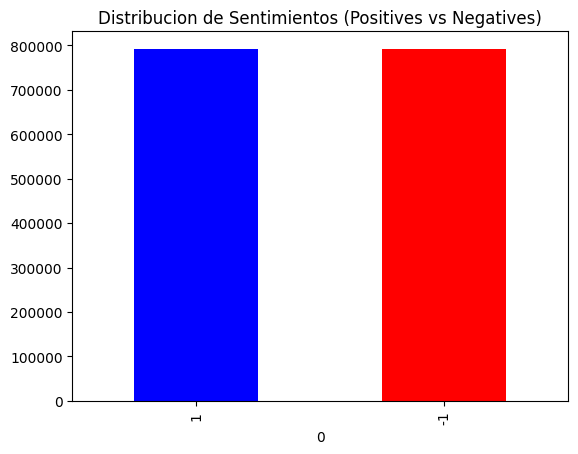

In [24]:
#Graficamos la distribucion de las etiquetas
df[first_column_name].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribucion de Sentimientos (Positives vs Negatives)')
plt.show()

In [25]:
#Ahora remplazamos los valores 1 por positivo y -1 por negativo
df[first_column_name] = df[first_column_name].replace(1, 'Positivo').replace(-1, 'Negativo')
print(df[first_column_name].value_counts())

0
Positivo    791281
Negativo    790184
Name: count, dtype: int64


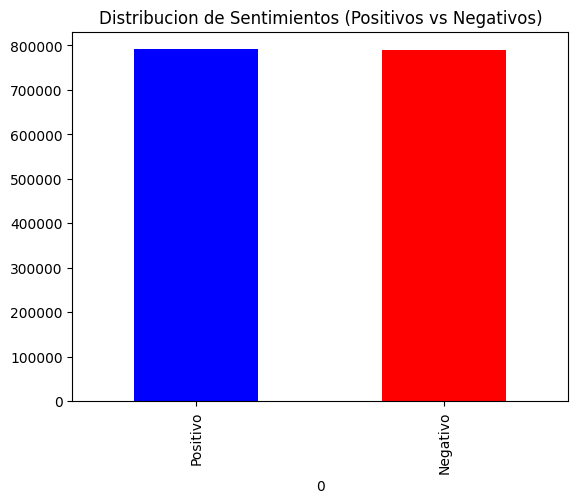

In [26]:
#Graficamos el nuevo sistema de etiquetas
df[first_column_name].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribucion de Sentimientos (Positivos vs Negativos)')
plt.show()

Transformación del Texto para Modelos de Aprendizaje Automático

In [27]:
#Unimos los tokens en una cadena de texto
df['clean_text'] = df['tokens'].apply(lambda x: ' '.join(x))

#Vectorizamos con Bag of words
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(df['clean_text'])

#Mostramos las primeras caracteristicas
print(vectorizer.get_feature_names_out()[:10])

['aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaa' 'aaaaaaa' 'aaaaaaaa' 'aaaaaaaaa'
 'aaaaaaaaaa' 'aaaaaaaaaaa']


In [28]:
#Vectorizamos con tf-idf
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])

#Mostramos las primeras caracteristicas
print(tfidf_vectorizer.get_feature_names_out()[:10])

['aa' 'aaa' 'aaaa' 'aaaaa' 'aaaaaa' 'aaaaaaa' 'aaaaaaaa' 'aaaaaaaaa'
 'aaaaaaaaaa' 'aaaaaaaaaaa']


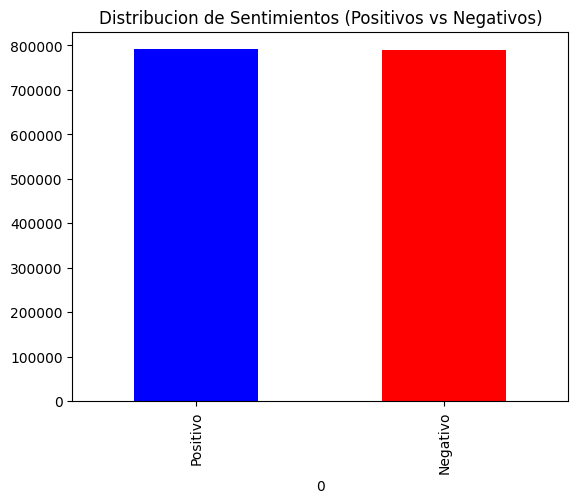

In [29]:
#Graficar la nueva distribucion de los sentimientos
df[first_column_name].value_counts().plot(kind='bar', color=['blue', 'red'])
plt.title('Distribucion de Sentimientos (Positivos vs Negativos)')
plt.show()

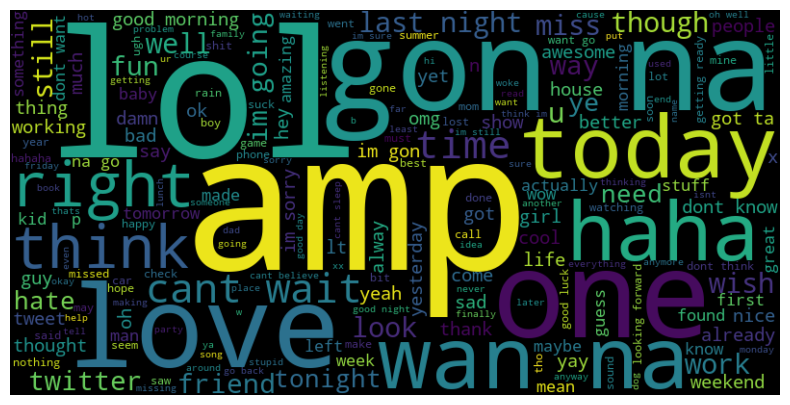

In [30]:
#Generamos la nube de palabras
wordcloud = WordCloud(width=800, height=400).generate(' '.join(todos_los_tokens))

#Mostramos la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

División de los datos para entrenamiento y prueba

In [31]:
#Etiquetas y caracteristicas
y = df[first_column_name]
X = X_tfidf

#Dividimos el dataset en entrenamiento (70%) y prueba (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Datos de entrenamiento: {X_train.shape}")
print(f"Datos de prueba: {X_test.shape}")

Datos de entrenamiento: (1107025, 409959)
Datos de prueba: (474440, 409959)


Implementación de un Modelo de Aprendizaje Automático

In [36]:
#Inicializamos el modelo
model = LogisticRegression()

#Entrenamos el modelo
model.fit(X_train, y_train)

#Predecimos los datos de prueba
y_pred = model.predict(X_test)

#Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.4f}\n")

print("Reporte de Clasificación\n")
#Mostramos el reporte de clasificacion
print(classification_report(y_test, y_pred))

Precisión del modelo: 0.7819

Reporte de Clasificación

              precision    recall  f1-score   support

    Negativo       0.80      0.76      0.78    236540
    Positivo       0.77      0.81      0.79    237900

    accuracy                           0.78    474440
   macro avg       0.78      0.78      0.78    474440
weighted avg       0.78      0.78      0.78    474440

